## Event Analysis Notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from tabulate import tabulate
import networkx as nx
import analysis_functions
import scipy.stats as stats

In [2]:
### Load Data 
voteData = pd.read_csv('data/votes.csv')
groupData = pd.read_csv('data/users_to_groups.csv')
forumQuestions = pd.read_csv('data/forum_questions.csv')
groupCategories = pd.read_csv('data/group_categories.csv')
questionOptions = pd.read_csv('data/question_options.csv')
userAttributes = pd.read_csv('data/user_attributes.csv')

# print("voteData:", len(voteData))
# print("groupData:", len(groupData))
# print("forumQuestions:", len(forumQuestions))
# print("groupCategories:", len(groupCategories))

### Transform Data 

In [3]:
credentials = analysis_functions.filter_and_extract_credential(userAttributes)
voteDataWithCredentials = analysis_functions.merge_dataframes(voteData, credentials)
voteDataWithCredentials['credential'].value_counts(dropna=False)
voteDataWithCredentials.groupby('user_id')['credential'].unique().value_counts(dropna=False)

credential
[None]         13
[PhD]           9
[Bachelors]     7
[Masters]       5
[JD]            2
Name: count, dtype: int64

In [4]:
### Define multipliers 
credential_to_multiplier = {
    'None': 1,
    'Bachelors': 1.5,
    'Masters': 2,
    'PhD': 2.5,
    'JD': 2.5
} 

In [5]:
# Create 'multiplier' and transform votes based on credentails 
voteDataWithCredentials['multiplier'] = voteDataWithCredentials['credential'].map(credential_to_multiplier)
voteDataWithCredentials['num_of_votes'] = voteDataWithCredentials['num_of_votes'] * voteDataWithCredentials['multiplier']


### Manual Analysis

In [6]:
# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# Specify an option id
option_id = '4ad65252-e651-460c-af6b-289769a3964b'

In [7]:
# Analysis of a given option id 
votes = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
filtered_votes = analysis_functions.filter_zero_votes(votes)
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, group_categories)
groups = analysis_functions.get_groups_by_user_and_optionid(groupData, filtered_votes, group_categories_ids)
memberships = analysis_functions.create_group_memberships(groups)
filtered_groups = analysis_functions.remove_duplicate_groups(groups)
plurality_score = analysis_functions.connection_oriented_cluster_match(filtered_groups, filtered_votes)

# print("votes:", votes)
# print("filtered_votes:", filtered_votes)
# print("group_categories_ids:", group_categories_ids)
# print("groups:", groups)
# print("memberships:", memberships)
# print("filtered_groups:", filtered_groups)
# print("plurality_score:", plurality_score)

### Voting Results Table  

In [8]:
# specify a question id 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'

# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']
group_categories_without_research_groups = ['affiliation']

# get list of option ids related to the question id 
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

In [9]:
# Generate Results 
results_dict = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories)
results_dict_with_multiplier = analysis_functions.get_results_dict(optionIds, voteDataWithCredentials, groupData, groupCategories, group_categories)
results_dict_without_research_groups = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories_without_research_groups)
results_dict_with_duplicates = analysis_functions.get_results_dict_with_duplicates(optionIds, voteData, groupData, groupCategories, group_categories)

In [10]:
# Insert display rank 
num_entries = len(results_dict) +1

# Assign display ranks
for i, key in enumerate(results_dict):
    results_dict[key]['displayRank'] = num_entries - 1 - i

In [11]:
# add a rank to each result category (plural score, raw votes, quadratic score)
results_dict_with_ranks = analysis_functions.calculate_ranks(results_dict)
results_dict_with_ranks_with_multiplier = analysis_functions.calculate_ranks(results_dict_with_multiplier)
results_dict_with_ranks_without_research_groups = analysis_functions.calculate_ranks(results_dict_without_research_groups)
results_dict_with_ranks_and_duplicates = analysis_functions.calculate_ranks(results_dict_with_duplicates)

# Sort results according to the plurality score
sorted_results_dict_with_ranks = dict(sorted(results_dict_with_ranks.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))
sorted_results_dict_with_ranks_with_multiplier = dict(sorted(results_dict_with_ranks_with_multiplier.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))
sorted_results_dict_with_ranks_without_research_groups = dict(sorted(results_dict_with_ranks_without_research_groups.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))
sorted_results_dict_with_ranks_and_duplicates = dict(sorted(results_dict_with_ranks_and_duplicates.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [12]:
merged_result_dict = analysis_functions.merge_dicts(results_dict_with_ranks, results_dict_with_ranks_and_duplicates)
sorted_merged_result_dict = dict(sorted(merged_result_dict.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [13]:
merged_result_dict_with_multiplier = analysis_functions.merge_dicts(results_dict_with_ranks, results_dict_with_ranks_with_multiplier)
sorted_merged_result_dict_with_multiplier = dict(sorted(merged_result_dict_with_multiplier.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [14]:
merged_result_dict_without_research_groups = analysis_functions.merge_dicts(results_dict_with_ranks, results_dict_with_ranks_without_research_groups)
sorted_merged_result_dict_without_research_groups = dict(sorted(merged_result_dict_without_research_groups.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [15]:
# Create data table 
table_data = []
headers = ['Options', 'Plurality Score', 'Quadratic Score', 'Raw Votes']

option_counter = 1

for option, data in sorted_results_dict_with_ranks.items():
    row = [f'Option {option_counter}']
    for category in ['pluralityScore', 'quadraticScore', 'totalRawVotes']:
        row.append(round(data[category]['score'], 3))
    table_data.append(row)
    option_counter += 1 

df = pd.DataFrame(table_data, columns=headers)

In [16]:
# Save and Print results 
# df.to_excel('plots-and-tables/voting_results.xlsx', index=False)
print(tabulate(df, headers='keys', tablefmt='pretty'))

+----+-----------+-----------------+-----------------+-----------+
|    |  Options  | Plurality Score | Quadratic Score | Raw Votes |
+----+-----------+-----------------+-----------------+-----------+
| 0  | Option 1  |      59.45      |     64.658      |    213    |
| 1  | Option 2  |     42.394      |     43.858      |    196    |
| 2  | Option 3  |     39.655      |     50.425      |    263    |
| 3  | Option 4  |     38.545      |     41.391      |    124    |
| 4  | Option 5  |     36.083      |     37.335      |    124    |
| 5  | Option 6  |     36.031      |     37.566      |    110    |
| 6  | Option 7  |     32.766      |     31.035      |    82     |
| 7  | Option 8  |      30.99      |     32.565      |    86     |
| 8  | Option 9  |     27.541      |     28.423      |    60     |
| 9  | Option 10 |     27.254      |     28.397      |    82     |
| 10 | Option 11 |     25.808      |     25.104      |    64     |
| 11 | Option 12 |     25.604      |      26.75      |    67  

### Correlation between initial ranking and final ranking 

In [17]:
# Extract display ranks and plurality score ranks
display_ranks = []
plurality_ranks = []
quadratic_ranks = []
raw_ranks = []

for key, value in sorted_results_dict_with_ranks.items():
    display_ranks.append(value['displayRank'])
    plurality_ranks.append(value['pluralityScore']['rank'])
    quadratic_ranks.append(value['totalRawVotes']['rank'])
    raw_ranks.append(value['quadraticScore']['rank'])

# Calculate Spearman's rank correlation coefficient
plurality_corr, _ = stats.spearmanr(display_ranks, plurality_ranks)
quadratic_corr, _ = stats.spearmanr(display_ranks, quadratic_ranks)
raw_corr, _ = stats.spearmanr(display_ranks, raw_ranks)

plurality_corr, quadratic_corr, raw_corr


(-0.10168067226890756, -0.03781512605042017, -0.08039215686274512)

### Vote Distribution

In [18]:
# Get the latest vote by user and option Id. 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'
group_categories = ['affiliation', 'private']
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

results = {}

# Loop through each option_id and process the votes
for option_id in optionIds:
    vote_dict = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
    filtered_vote_dict = analysis_functions.filter_zero_votes(vote_dict)
    results[option_id] = filtered_vote_dict

In [19]:
# Get option owners 
option_owners = questionOptions[questionOptions['question_id'] == question_id][['id', 'user_id']]

In [20]:
# Calculate the votes for each option owner
for idx, row in option_owners.iterrows():
    option_id = row['id']
    owner_id = row['user_id']
    
    # Get the votes dictionary for this option
    votes = results.get(option_id, {})
    
    # Calculate the number of votes the owner placed on their own option
    own_votes = votes.get(owner_id, 0)
    
    # Calculate the sum of votes the owner placed on other options
    other_votes = 0
    other_options_count = 0
    for option, user_votes in results.items():
        if option != option_id:
            votes_for_other_option = user_votes.get(owner_id, 0)
            if votes_for_other_option > 0:
                other_votes += votes_for_other_option
                other_options_count += 1
    
    # Update the DataFrame with calculated values
    option_owners.at[idx, 'own_option'] = own_votes
    option_owners.at[idx, 'other_options'] = other_votes
    option_owners.at[idx, 'other_options_count'] = other_options_count

# Calculate total allocation of hearts
option_owners['total_allocation'] = option_owners['own_option'] + option_owners['other_options']


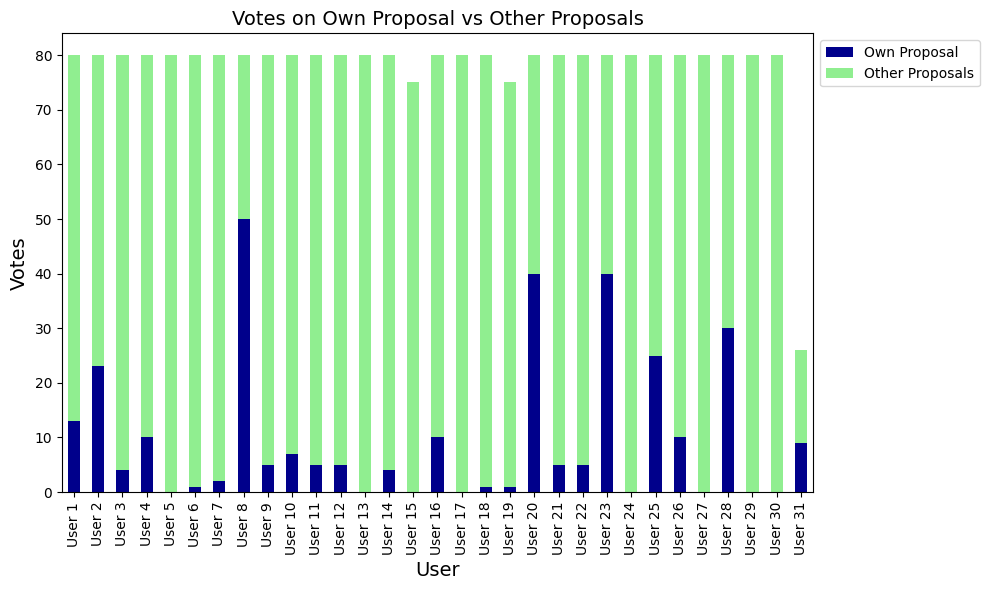

In [21]:
# Filter out rows where both own_option and other_options are 0
filtered_option_owners = option_owners[(option_owners['own_option'] != 0) | (option_owners['other_options'] != 0)].copy()

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

filtered_option_owners['user_placeholder'] = ['User ' + str(i + 1) for i in range(len(filtered_option_owners))]
filtered_option_owners.plot(kind='bar', x='user_placeholder', y=['own_option', 'other_options'], stacked=True, ax=ax, color=['darkBlue', 'lightGreen'])

ax.legend(['Own Proposal', 'Other Proposals'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('User', fontsize=14)
ax.set_ylabel('Votes', fontsize=14)
ax.set_title('Votes on Own Proposal vs Other Proposals', fontsize=14)
ax.set_xticks(range(len(filtered_option_owners)))
ax.set_xticklabels(filtered_option_owners['user_placeholder'], rotation=90, ha='center')

plt.tight_layout()
plt.savefig('plots-and-tables/vote_distribution.png')

In [22]:
filtered_option_owners['other_options_count'].mean(), filtered_option_owners['other_options_count'].median(), filtered_option_owners['other_options_count'].min(), filtered_option_owners['other_options_count'].max()

(9.64516129032258, 10.0, 1.0, 28.0)

### Result Visualizations

#### Ranking Distribution

In [23]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'quadraticScore', 'totalRawVotes']
custom_labels = ['Plurality Score Rank', 'Quadratic Score Rank', 'Raw Votes Rank']

# Get the number of options
num_options = len(sorted_results_dict_with_ranks)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

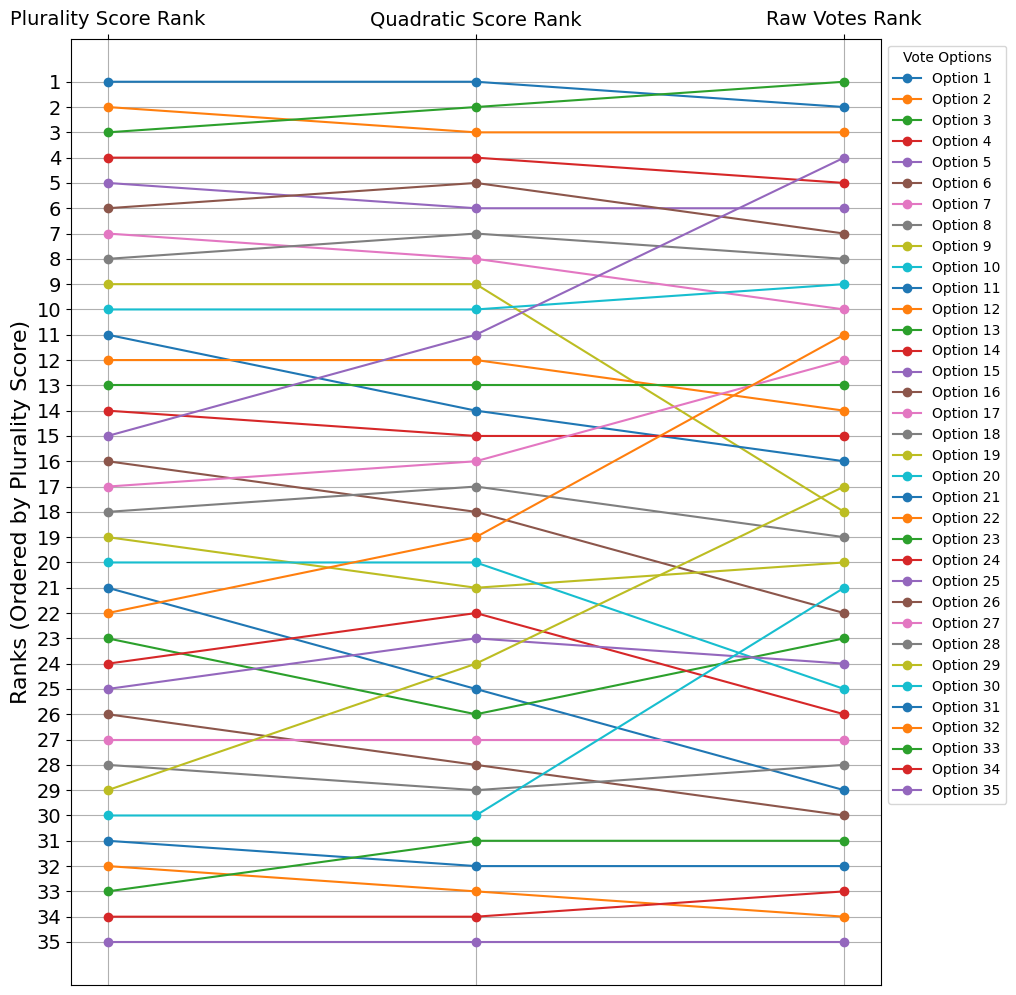

In [24]:
# Bump Chart 
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=colors[i])

plt.gca().invert_yaxis() 
plt.yticks(range(1, max(ranks) + 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels)
plt.tight_layout()
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart.png')

#### Highlighted Ranking Distribution

In [25]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_results_dict_with_ranks.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

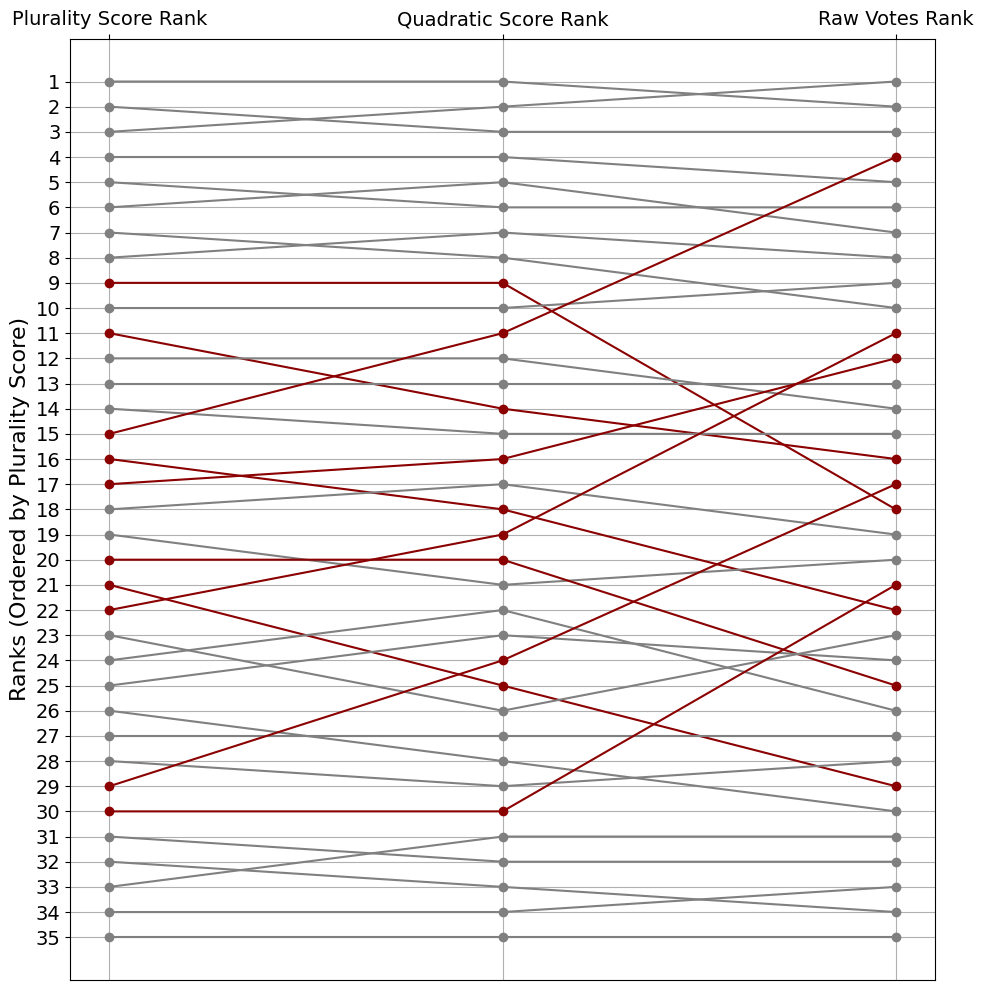

In [26]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 4:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_legend.png')

### Ranking Distribution with and without duplicate entries 

In [27]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'pluralityScoreComparison']
custom_labels = ['Plurality Score Rank', 'Plurality Score Rank With Duplicates']

# Get the number of options
num_options = len(sorted_merged_result_dict)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

In [28]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_merged_result_dict.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

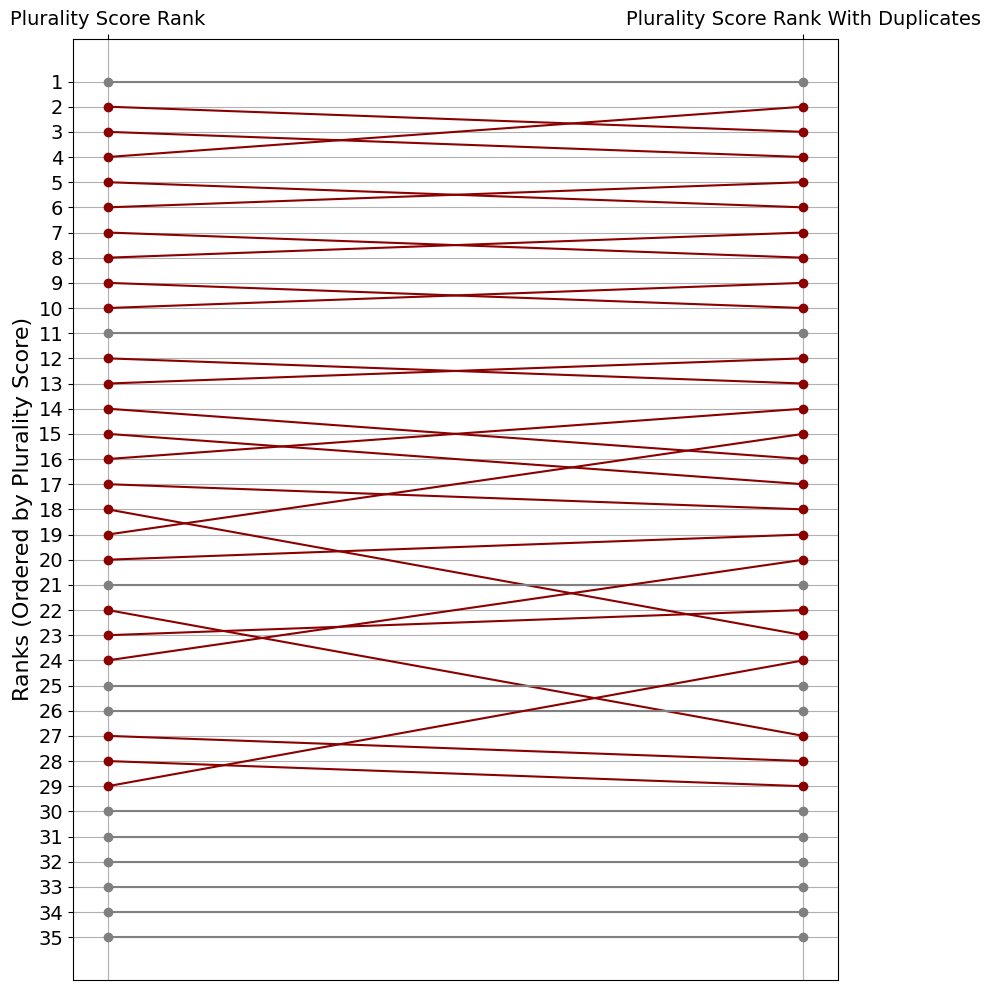

In [29]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_merged_result_dict.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 0:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_with_duplicates.png')

### Ranking Distribution with and without multipliers based on credentails 

In [30]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'pluralityScoreComparison']
custom_labels = ['Plurality Score Rank', 'Plurality Score Rank With Multiplier']

# Get the number of options
num_options = len(sorted_merged_result_dict_with_multiplier)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

In [31]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_merged_result_dict_with_multiplier.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

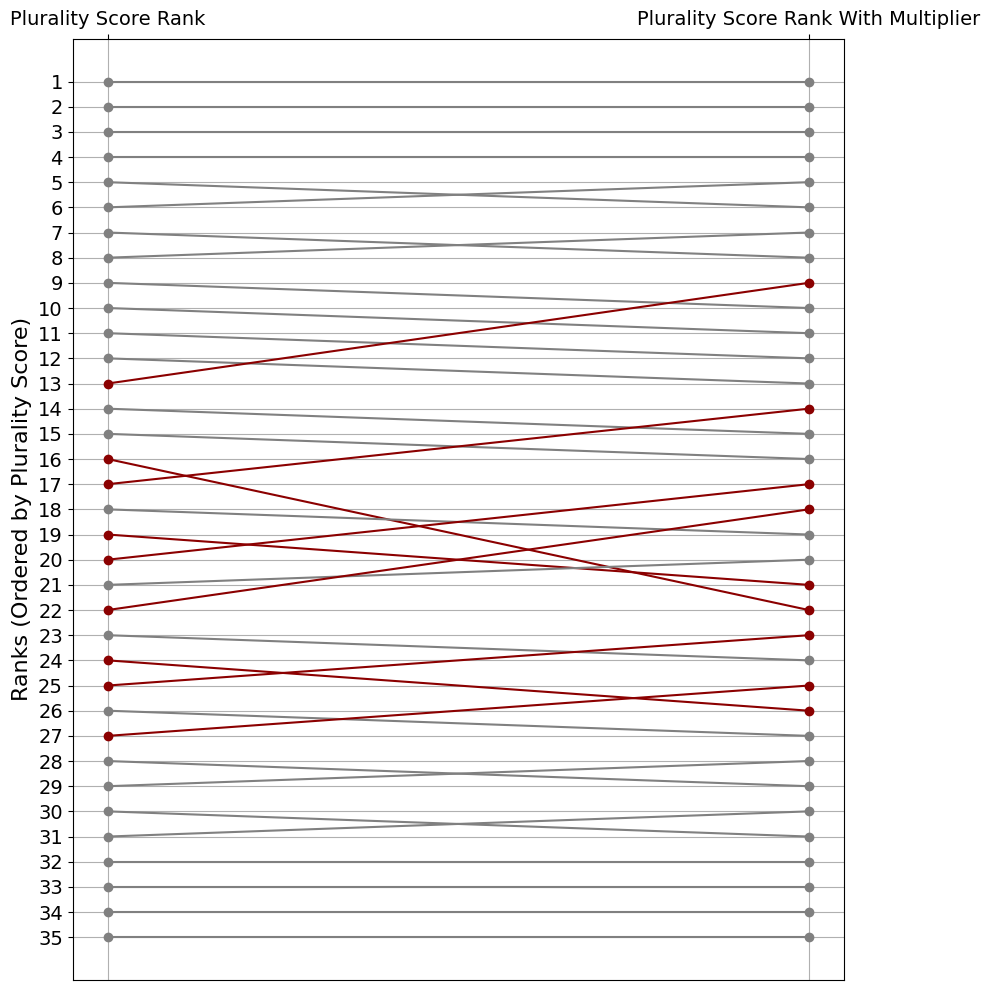

In [32]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_merged_result_dict_with_multiplier.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 1:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_with_multiplier.png')

### Ranking Distribution with and without research groups

In [33]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'pluralityScoreComparison']
custom_labels = ['Plurality Score Rank', 'Plurality Score Rank Without Research Groups']

# Get the number of options
num_options = len(sorted_merged_result_dict_without_research_groups)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

In [34]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_merged_result_dict_without_research_groups.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

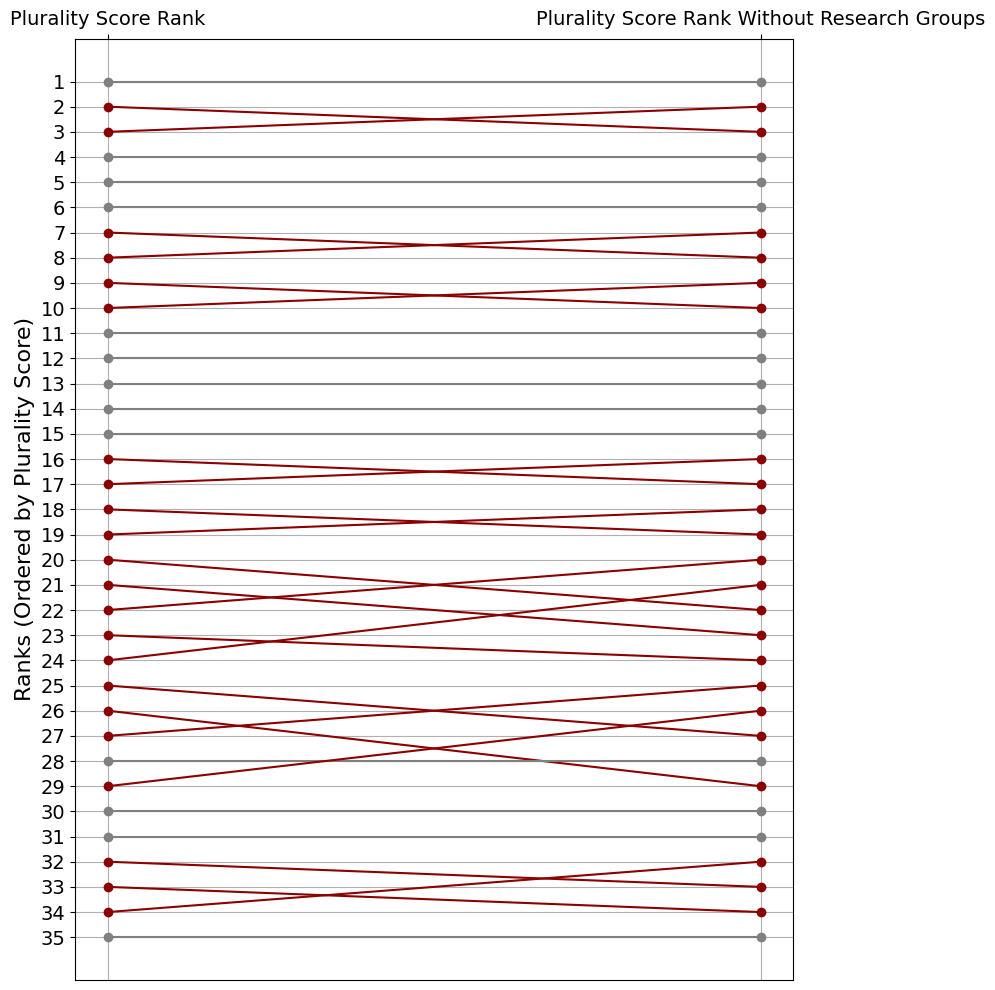

In [35]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_merged_result_dict_without_research_groups.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 0:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_research_groups.png')

### Network Visualization

In [36]:
# filter group data by users who voted and by relevant group categories 
distinct_user_ids = voteData['user_id'].unique().tolist()
filtered_group_users = groupData[groupData['user_id'].isin(distinct_user_ids)]
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, names=['affiliation', 'private'])
filtered_group_users_categories = filtered_group_users[filtered_group_users['group_category_id'].isin(group_categories_ids)]

print("Number of unique users:", filtered_group_users['user_id'].nunique())
print("Number of group categories:", filtered_group_users_categories['group_category_id'].nunique())
print("Length of group data:", len(filtered_group_users_categories))

Number of unique users: 36
Number of group categories: 2
Length of group data: 60


In [37]:
# Group by 'user_id' and aggregate 'group_id' and 'group_category_id' into lists
reduced_filtered_group_users_categories = filtered_group_users_categories.groupby('user_id').agg({'group_id': list, 'group_category_id': list}).reset_index()
reduced_filtered_group_users_categories.head()

,user_id,group_id,group_category_id
0,03aaaaa7-04f7-4c50-9471-7fc8a91adb98,[5a339142-3ff3-4c11-9c5d-fd84878e164b],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
1,03e5cafe-075a-4085-9e4d-3f960bb04219,[28317618-cd94-49c5-9662-dee37e14970b],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
2,05d7780a-aa90-4cc4-b82c-74e121e11c90,[6bffe6f8-e3ea-44c2-8b34-a840374d79de],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
3,0ae4ca12-23e6-44b5-ba9e-7dcb630270d5,[d7c66736-d56b-4bb1-a70f-bf05ee739169],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
4,0f8e54b6-bd20-41d0-8957-143af5572483,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8]


In [38]:
# Get Network Nodes
all_user_ids = set(filtered_group_users_categories['user_id'])
node_list = [{'id': user_id} for user_id in all_user_ids]

# Get Network Edges
edge_list = []

grouped = filtered_group_users_categories.groupby('group_id')
for group_id, group_data in grouped:
    # Create pairs of users within the group
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edge_list.append({'source': group_data.iloc[i]['user_id'], 'target': group_data.iloc[j]['user_id']})

edge_df = pd.DataFrame(edge_list)

In [39]:
# Create edge attribute highlighting the affiliation relationship between nodes 
 
merged_df = pd.merge(edge_df, reduced_filtered_group_users_categories, left_on='source', right_on='user_id', suffixes=('', '_source'))
merged_df = pd.merge(merged_df, reduced_filtered_group_users_categories, left_on='target', right_on='user_id', suffixes=('', '_target'))

# Define function to find common groups and group categories
def find_shared_groups_and_categories(row):
    source_groups = set(row['group_id'])
    target_groups = set(row['group_id_target'])
    shared_groups = source_groups.intersection(target_groups)
    
    shared_group_categories = []
    for group in shared_groups:
        source_category = row['group_category_id'][row['group_id'].index(group)]
        target_category = row['group_category_id_target'][row['group_id_target'].index(group)]
        if source_category == target_category:
            shared_group_categories.append(source_category)
        else:
            shared_group_categories.extend([source_category, target_category])
    
    return pd.Series([list(shared_groups), list(set(shared_group_categories))])

# Apply the function to each row and create new columns 'shared_groups' and 'shared_group_categories'
merged_df[['shared_groups', 'shared_group_categories']] = merged_df.apply(find_shared_groups_and_categories, axis=1)

# Define function to determine edge attribute
def determine_edge_attribute(shared_group_categories):
    shared_categories_set = set(shared_group_categories)
    if '0419db52-cda8-4cf2-adb2-a881234ea1f8' in shared_categories_set and 'b1862f74-458c-4eb8-9445-1ccf9ccd1712' in shared_categories_set:
        return 'both'
    elif shared_categories_set == {'0419db52-cda8-4cf2-adb2-a881234ea1f8'}:
        return 'affiliation'
    elif shared_categories_set == {'b1862f74-458c-4eb8-9445-1ccf9ccd1712'}:
        return 'private'
    return None

merged_df['edge_attribute'] = merged_df['shared_group_categories'].apply(determine_edge_attribute)

edge_df_new = merged_df[['source', 'target', 'edge_attribute']]
# edge_df_new.head()

In [40]:
# TODO: Need to look into duplicate edges (however no impact on results)
# duplicate_edges = edge_df_new[edge_df_new.duplicated(subset=['target', 'source'], keep=False)]
# duplicate_edges

# Sorting the values in each row to ensure the order doesn't matter
# edge_df_new[['source', 'target']] = pd.DataFrame(np.sort(edge_df_new[['source', 'target']], axis=1), index=edge_df_new.index)

# Finding duplicates
# duplicates = edge_df_new[edge_df_new.duplicated(subset=['source', 'target'], keep=False)]

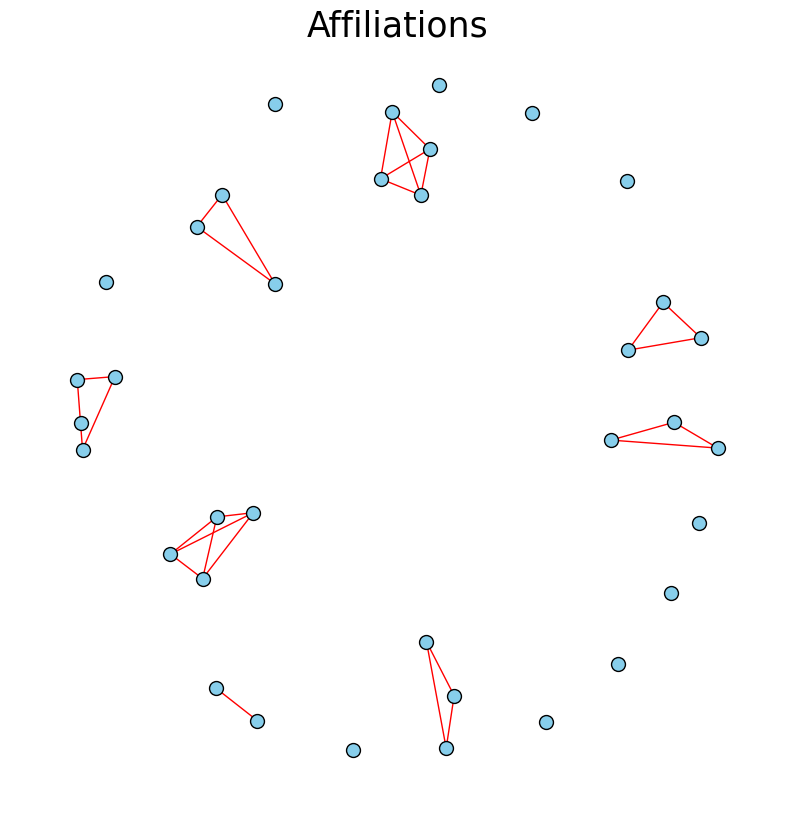

<Figure size 640x480 with 0 Axes>

In [41]:
# Create a new figure for the single plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create G1: Only "affiliation" and "both" edges
G1 = nx.Graph()
G1.add_nodes_from([node['id'] for node in node_list])
edges1 = [(row['source'], row['target']) for _, row in edge_df_new.iterrows() if row['edge_attribute'] in ['affiliation', 'both']]
G1.add_edges_from(edges1)

# Use the Fruchterman-Reingold layout for positioning nodes
pos = nx.fruchterman_reingold_layout(G1, k=4, iterations=500, scale=1.5, seed=6)

# Draw Graph 1 with red edges
nx.draw(G1, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color='red', ax=ax)
ax.set_title('Affiliations', fontsize=25)

# Show the plot
plt.show()

# Optionally, save the plot as a PNG file
plt.savefig('plots-and-tables/network_p1.png')

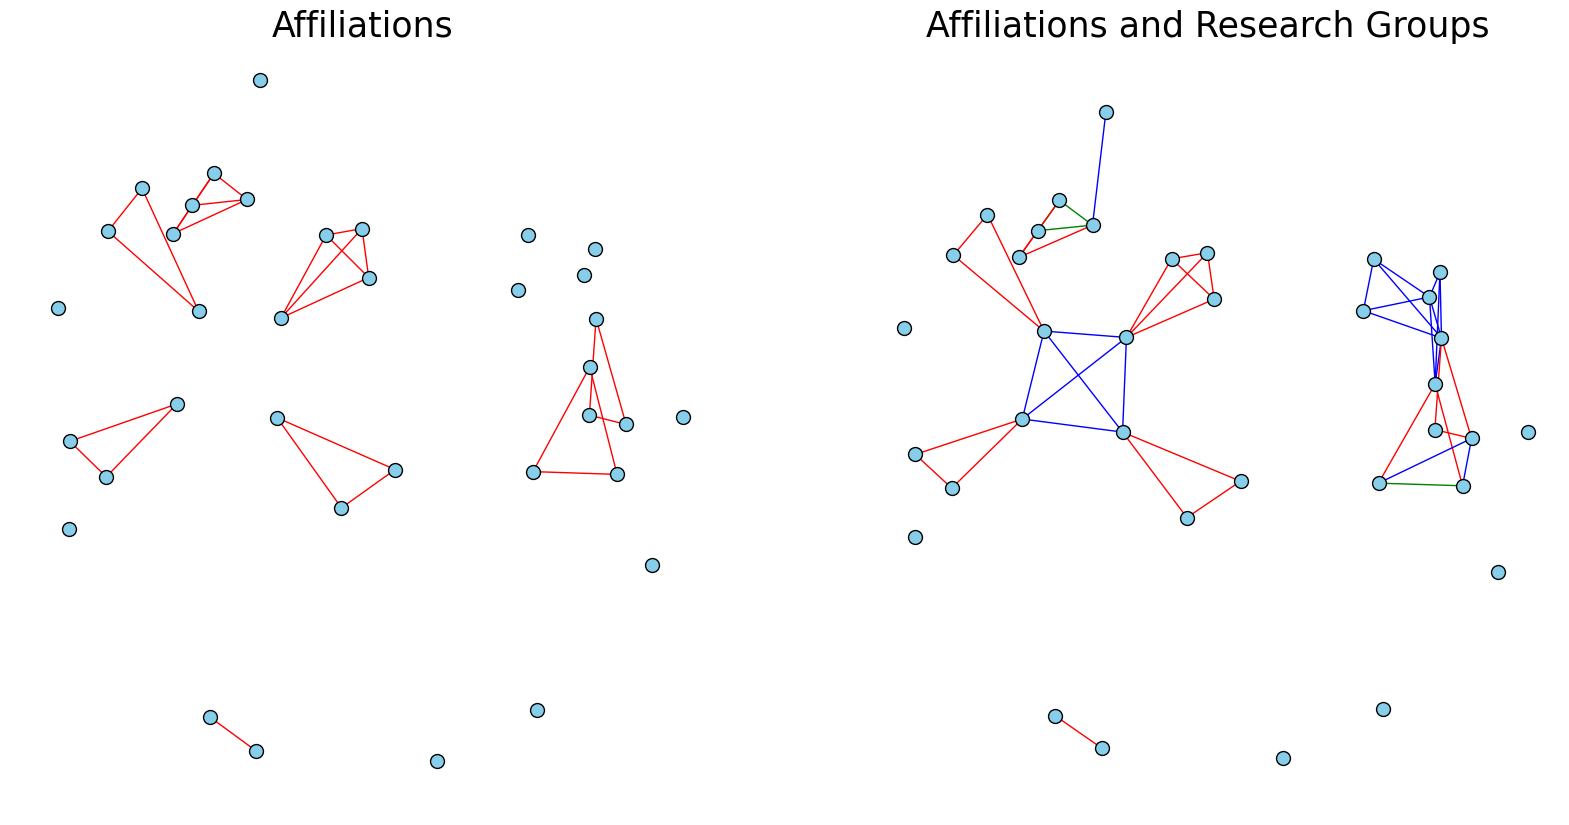

In [42]:
# Create network  plot
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 2: Edges colored based on their attributes using a colormap
G2 = nx.Graph()
G2.add_nodes_from([node['id'] for node in node_list])
for _, row in edge_df_new.iterrows():
    G2.add_edge(row['source'], row['target'], edge_attribute=row['edge_attribute'])

# Use the Fruchterman-Reingold layout for positioning nodes
pos = nx.fruchterman_reingold_layout(G2, k=4, iterations=500, scale=1.5, seed=6)

# Create a colormap based on edge attributes
edge_colors2 = []
edge_color_map = {'affiliation': 'red', 'private': 'blue', 'both': 'green'}
for edge in G2.edges():
    edge_attribute = G2[edge[0]][edge[1]]['edge_attribute']
    edge_colors2.append(edge_color_map[edge_attribute])

# Draw the network
nx.draw(G2, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color=edge_colors2, ax=axes[1])
axes[1].set_title('Affiliations and Research Groups', fontsize=25)

# Plot 1: Only "affiliation" and "both" edges, all in red
G1 = nx.Graph()
G1.add_nodes_from([node['id'] for node in node_list])
edges1 = [(row['source'], row['target']) for _, row in edge_df_new.iterrows() if row['edge_attribute'] in ['affiliation', 'both']]
G1.add_edges_from(edges1)

# Use the same layout positions as G2
pos = nx.fruchterman_reingold_layout(G1, pos=pos, fixed=pos.keys(), seed=6)

# Draw Graph 1 with red edges
nx.draw(G1, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color='red', ax=axes[0])
axes[0].set_title('Affiliations', fontsize=25)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/network.png')
